<a href="https://colab.research.google.com/github/ResByte/unet-segment/blob/master/segmentation_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# # to install pytorch uncomment these line 
!pip3 install torch torchvision

In [0]:
!mkdir data
!wget -O ./data/ADEChallengeData2016.zip http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ./data/ADEChallengeData2016.zip -d ./data

In [0]:
import os 
import numpy as np 
import cv2
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
list_files = os.listdir('./data/ADEChallengeData2016')

In [7]:
list_files

['sceneCategories.txt', 'images', 'annotations', 'objectInfo150.txt']

In [0]:
image_path = os.path.join('./data/ADEChallengeData2016', 'images')
ann_path = os.path.join('./data/ADEChallengeData2016', 'annotations')

In [0]:
def get_file_lists(data_path, file_format='*.png'):
    data_train_files = os.listdir(os.path.join(data_path,'training'))
    data_val_files = os.listdir(os.path.join(data_path,'validation'))
    train_files = [os.path.join(data_path, 'training',x) for x in data_train_files ]
    val_files = [os.path.join(data_path, 'validation',x) for x in data_val_files ]
    return sorted(train_files), sorted(val_files)

train_imgs, val_imgs = get_file_lists(image_path)

In [0]:
train_anns, val_anns = get_file_lists(ann_path)

In [42]:
len(train_imgs), len(val_imgs), len(train_anns), len(val_anns)

(20210, 2000, 20210, 2000)

In [43]:
val_anns[0], val_imgs[0]

('./data/ADEChallengeData2016/annotations/validation/ADE_val_00000001.png',
 './data/ADEChallengeData2016/images/validation/ADE_val_00000001.jpg')

In [125]:
!wget -O ./data/color150.mat https://github.com/CSAILVision/semantic-segmentation-pytorch/raw/master/data/color150.mat 

--2018-11-11 02:05:05--  https://github.com/CSAILVision/semantic-segmentation-pytorch/raw/master/data/color150.mat
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/CSAILVision/semantic-segmentation-pytorch/master/data/color150.mat [following]
--2018-11-11 02:05:05--  https://raw.githubusercontent.com/CSAILVision/semantic-segmentation-pytorch/master/data/color150.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502 [application/octet-stream]
Saving to: ‘./data/color150.mat’

./data/color150.mat 100%[===================>]     502  --.-KB/s    in 0s      

2018-11-11 02:05:05 (51.7

In [0]:
from scipy.io import loadmat

colors = loadmat('./data/color150.mat')['colors']

In [0]:
def plot_data(img_path, ann_path):
  img = cv2.imread(img_path)
  img = cv2.resize(img,(224, 224))
  ann = cv2.imread(ann_path)
  ann = ann[:,:,0]
  ann = cv2.resize(ann,(224, 224))
  #   print(np.array_equal(ann[:,:,0], ann[:,:,1]))
#   ann = cv2.cvtColor(ann, cv2.COLOR_BGR2GRAY)
  print(img.shape, ann.shape, np.min(ann), np.max(ann))
  f, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 14))
  ax[0].imshow(ann,cmap='gray')
  ax[0].grid('off')
  ax[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  ax[1].grid('off')

(224, 224, 3) (224, 224) 0 109


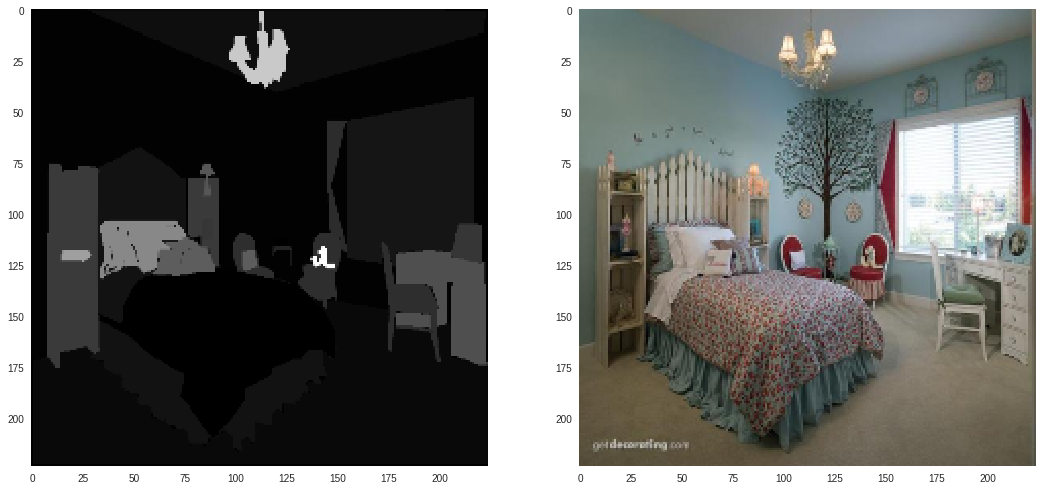

In [133]:
plot_data(val_imgs[243], val_anns[243])

## Dataset Loader 


In [0]:
import torch 
import torch.nn as nn 
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [0]:
class ADEData(Dataset):
  def __init__(self,root = './data/ADEChallengeData2016', is_train=True, resize=224):
    self.root = root 
    self.prepare_data()
    self.is_train = is_train
    self.resize = resize
    self.img_transform = transforms.Compose([
            transforms.Normalize(mean=[102.9801, 115.9465, 122.7717], std=[1., 1., 1.])
            ])
    if self.is_train:
      print(len(self.train_imgs))
    else:
      print(len(self.val_imgs))
    
  def prepare_data(self):
    image_path = os.path.join(self.root, 'images')
    ann_path = os.path.join(self.root, 'annotations')
    self.train_anns, self.val_anns = self.get_file_lists(ann_path)
    self.train_imgs, self.val_imgs = self.get_file_lists(image_path)
    assert len(self.train_imgs) == len(self.train_anns)
    assert len(self.val_imgs) == len(self.val_anns)
    
  def get_file_lists(self, data_path):
    data_train_files = os.listdir(os.path.join(data_path,'training'))
    data_val_files = os.listdir(os.path.join(data_path,'validation'))
    train_files = [os.path.join(data_path, 'training',x) for x in data_train_files ]
    val_files = [os.path.join(data_path, 'validation',x) for x in data_val_files ]
    return sorted(train_files), sorted(val_files)
  
  def load_image(self, img_path, ann_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert colors 
    img = cv2.resize(img,(self.resize,self.resize)) # resize to a fixed size
    img = img.astype(np.float32)
    img = img.transpose(2, 0, 1) # (H, W, C) --> (C, H, W)
    img = self.img_transform(torch.from_numpy(img.copy()))
    
    ann = cv2.imread(ann_path)
    ann = ann[:,:,0] # since all the channels have same values. 
    ann = cv2.resize(ann,(self.resize,self.resize))
    ann = ann[np.newaxis,:,:]
    return img, torch.from_numpy(ann.astype(np.int)).long()
  
  def __getitem__(self, index):
    if self.is_train:
      return self.load_image(self.train_imgs[index], self.train_anns[index])
    else:
      return self.load_image(self.val_imgs[index], self.val_anns[index])
  
  def __len__(self):
    if self.is_train:
      return len(self.train_imgs)
    else:
      return len(self.val_imgs)
    

In [182]:
train_data = ADEData(is_train=True)
val_data = ADEData(is_train=False)
img, ann = val_data[0]
img.shape, ann.shape

20210
2000


(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

In [0]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=1, drop_last=True)
val_loader = DataLoader(val_data, batch_size=1, shuffle=False, num_workers=1, drop_last=True)


## Model

In [174]:
import torch 
import torch.nn as nn 
from torch.nn import functional as F 
from torch.autograd import Variable
print(torch.__version__)

def upsampling(in_channels, out_channels, bilinear=False):
    if bilinear :
        return nn.Upsample(mode='bilinear',
                    scale_factor=2,
                    align_corners=True)
    else:
        return nn.ConvTranspose2d(in_channels,
                    out_channels,
                    kernel_size=2,
                    stride=2)

class DownSample(nn.Module):
    """
    Downsampling block in the U-Net structure.
    This consists of :
        - Conv3x3 + relu
        - Conv3x3 + relu
        - maxpool2x2
    """
    def __init__(self, in_channels=3, out_channels=64):
        super(DownSample, self).__init__()
        # backbone of downsampling 
        self.main = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, 
                                    kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(),
                        nn.Conv2d(out_channels, out_channels, 
                                    kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        x = self.main(x)
        return self.pool(x), x

class UpSample(nn.Module):
    """
    Upsampling module of the U-Net Structure
    This consists of :
        - conv 3x3 + relu
        - conv 3x3 + relu
        - upsample/upconv 2x2
    Params:
        - Cropped layer from previous
    """
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(UpSample, self).__init__()
        self.main = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, 
                            kernel_size=3,stride=1,padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(),
                        nn.Conv2d(out_channels, out_channels, 
                            kernel_size=3, stride=1,padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.upsample =  upsampling(in_channels, in_channels, 
                            bilinear=bilinear)
        
    def forward(self, x, y):
        x = self.upsample(x)
        # print(f"upsamples x : {x.shape} and y has {y.shape}")
        x = torch.cat([x, y], dim=1)
        # print(f"concat x : {x.shape}")
        return self.main(x)


0.4.1


In [0]:
class Unet(nn.Module):
    r"""Overall unet structure 
    Ex: for a depth of 1
    conv3x3 ->conv3x3-->crop_and_add-->conv3x3-->conv3x3-->conv1x1--> out
                 |                      / \
                \ /                      |
            max_pool2x2              upsample2x2
                 |                      / \
                \ /                      |
               conv3x3        -->     conv3x3
    """
    def __init__(self,
        in_channels=3, 
        nb_filters = 64,
        depth = 3,
        nb_classes=10,
        upsample_mode='bilinear'):
        
        super(Unet,self).__init__()
        self.in_channels = in_channels
        self.nb_filters = nb_filters
        self.depth = depth
        self.nb_classes = nb_classes
        self.upsample_mode = upsample_mode
        self.down_convs = []
        self.up_convs = []

        for i in range(depth):
            if i ==0:
                ins = self.in_channels
            else:
                ins = outs
            # increase the number of filters as  2^depth
            outs = self.nb_filters*(2**(i)) 

            # create downsampling block for this ins-->outs
            down_conv = DownSample(ins, outs)

            self.down_convs.append(down_conv)
        
        # bottom 
        self.bottom = nn.Conv2d(outs, outs, kernel_size=3,stride=1, padding=1, bias=False)

        # start with previous depth and create upconv blocks
        for i in range(depth):
            ins = outs 
            outs = ins // 2

            # using bilinear up convolutions
            up_conv = UpSample(ins*2, outs, bilinear=True)
            self.up_convs.append(up_conv)
        
        #final layer
        self.out_conv = nn.Conv2d(outs, self.nb_classes, 
                            kernel_size=1, stride=1)
        
        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)

    def forward(self, x):
        # Forward pass 
        downs = [] 
        for down in self.down_convs:
            x, unpooled_x = down(x)
            print(f"downsampling with {x.shape}")
            downs.append(unpooled_x)

        x = self.bottom(x)

        for i,ups in enumerate(self.up_convs):
            print(f"Upsampling with {x.shape} and {downs[-i-1].shape}")
            x = ups(x,downs[-i-1])

        x = self.out_conv(x)
        return x   

In [0]:
device = torch.device("cpu")#("cuda" if torch.cuda.is_available() else "cpu")

In [183]:
x = Variable(torch.randn((1, 3, 224, 224)))
model = Unet(depth=3,nb_classes=1)
out = model(x)
print(f"input with {x.shape} and output with {out.shape}")

downsampling with torch.Size([1, 64, 112, 112])
downsampling with torch.Size([1, 128, 56, 56])
downsampling with torch.Size([1, 256, 28, 28])
Upsampling with torch.Size([1, 256, 28, 28]) and torch.Size([1, 256, 56, 56])
Upsampling with torch.Size([1, 128, 56, 56]) and torch.Size([1, 128, 112, 112])


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


Upsampling with torch.Size([1, 64, 112, 112]) and torch.Size([1, 64, 224, 224])
input with torch.Size([1, 3, 224, 224]) and output with torch.Size([1, 1, 224, 224])


In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [0]:
criterion = criterion.to(device)

In [0]:
def train(epoch):
    model.train()
    train_loss = 0
    log_interval = 10
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = criterion(recon_batch, label)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            label = label.to(device)
            recon_batch = model(data)
            test_loss += criterion(recon_batch, label).item()


    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


In [196]:
model= model.to(device)

RuntimeError: ignored

In [193]:
for epoch in range(1, 2):
    train(epoch)
    test(epoch)


RuntimeError: ignored